In [ ]:
# default_exp model

# model

> The base class for constructing `amppl` models.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import numpy
import contextvars

In [ ]:
#export

import jax
import jax.scipy as jsc
import jax.numpy as jnp
from jax import grad, jit, value_and_grad
import numpy
import scipy
from tqdm import tqdm
import scipy.signal as signal
from matplotlib import pyplot
import seaborn

from collections import namedtuple
from inspect import isclass
from jax.tree_util import Partial
from functools import partial



In [ ]:
#export
from amppl import distributions as dists

from amppl.distributions import DistributionDefinitions

### Random Variables

Variables comprise one of the fundamental building blocks of a statistical model. Each variable in a statistical model is usually associated with some probability distribution. The `RV` describes this connection.

In [ ]:
#export
class RV():
    def __init__(self, name, distribution, shape=1, comp_dist=False, *args, **kwargs ):
        """
        ****
        **Arguments:**
        
        `name` (str): the name the variable is stored under
        
        `distribution` (Distribution class or instance): The Distribution that the variable follows
        
        *args, **kwargs: Arguments passed to the distribution's logpdf
        
        ****
        **Attributes:**
        
        `bijection` (callable): The bijection that transforms between constrained and \
        unconstrained representations of the parameters
        
        `current_logprob` (float): The log-probability of the last evaluated value
        """
        self.name=name
        self.comp_dist=comp_dist
        self.shape=shape
        self.eval_count=0
        if isclass(distribution)==True: #Initialized the class
            self.distribution=distribution(*args, **kwargs)
        else:
            self.distribution=distribution
#         print (dir(self.distribution))
#         self.distribution=distribution(*args, **kwargs)

        self.bijection=self.distribution.bijection
        self.args=args
        self.kwargs=kwargs

    def logp(self,value, use_mean=False,*args, **kwargs):
        """Evaluate the log-probability of a value.
        
        ****
        **Arguments:**
        
        `value`: The value at which to evaluate the distribution
        
        `use_mean`: Whether to average the log-probabilities across all elements in value \
        rather than sum them.
        
        ****
        **Returns:** The log-probability. Also stores this result in self.current_logprob
        """
        self.eval_count+=1
        result=self.distribution.logp(value, *args,**kwargs)
        self.elementwise_logprob=result
        
        if self.comp_dist==True:
            self.current_logprob=0.
            return result
        if use_mean==True:
            self.wt=jnp.sum(0*result+1)
            self.current_logprob= jnp.mean(result)
        else:
            self.wt=1.
            self.current_logprob= jnp.sum(result)
        return self.current_logprob

In [ ]:
# a=Variable('positive_number', 5, lower=0)

In [ ]:
# a=RV('mean',jsc.stats.norm.logpdf, 5, )

In [ ]:
# class Distribution():
#     def __init__(self, logp, rvs,):

In [ ]:
# test_model.names

### Specifying a model: The ModelBase

To fit a (Bayesian) statistical model there are three main things that we need to do.

1. Describe the structure of the model. That is, how the different variables relate to each other and to the observed data

2. For any valid set of parameter values, compute the probability of the model given the data

3. Explore the set of valid parameters to find the best values (without ever encountering invalid parameter values)


While the tools for optimizing the model to find the best parameter should be relegated to an optimizer class, such as `GradientDescent`, the parenthetical in goal 3 is closely related to the first two goals. That is, a statistical model should know how to the model is structured, it should know how to find valid parameter values, and it should be able to compute probabilities under the model. However, each time I define a model, I don't want to have to write code to accomplish these different steps. I want to be able to spend all of my time thinking about how the model is structured, and none of my time worrying about math or book-keeping. 

To this end, the `ModelBase` class provides the methods and attributes need to organize models so as to accomplish these goals. 



In [ ]:
#export


# I want to modify this so that I extract or update specific subset of parameters, so that I can
# easily compute Hessians describing specific groups of parameters. I think this would require
# adding an option to assign an RV to a group when it is defined. But is there a more general
# structure that would do what I want?

# Basically, the problem is: How can I make it easy to specify a specific subset of parameters?
class ModelBase(DistributionDefinitions):
    """A class template for constructing statistical models programmatically. This should be supplied 
    as a base class to a statistical model. For example, to write a model named `LinearModel`:
    
    ```
    @Model
    class LinearModel(ModelBase):
        def model(self, *args, **kwargs):
            `code goes here`
    ```        """

    def __init__(self, 
                 compute_value_and_grad=False,
                 compute_logp_with_weighted_average=False):
        super().__init__()
        self.stochastic=False
        self.RVs={}
        self.variables={}
        self.vector_labels=[]
        self.rv_labels=[]
        
        self.transformations=[] 
        self.parameters={}
        self.label_dict={}
        self.state=[]
        self.comments={}
        
        self.prior_draw=False
        self.compute_logp_with_weighted_average=compute_logp_with_weighted_average
        self.compute_value_and_grad=compute_value_and_grad
        if self.compute_value_and_grad==True:
            self.value_and_grad=jit(value_and_grad(self.set_state_and_evaluate))
    
    
    
    # I want to modify this to store additional information about random variables
    # The behavior I want 
    def RV(self, name=None, dist=None,  value=None,
           shape=1, as_dist=False,label=None,comment='',
          *args,**kwargs):
        """The method which allows models to be constructed programmatically. Calling .RV accomplishes three \
        things:

        1. If RV has not yet been called with the specified name, it adds an RV with \
        that name to the model

        2. If the RV has been called, it evaluates the probability of the RV's current values \
        and stores this in the RV

        3. It returns the current value of the RV
            
        Thus the output of RV is numerical and can be operated on like any other number. Equally important, \
        this means it can be passed as the parameters of another RV.
        
        Note: A number of predefined RVs are inhereted from the `DistributionDefinition` base class, and \
        using these generally makes for more readable code
        
        ****
        **Arguments:**
        
        `name` (str): The name of the variable

        `dist` (string or instance of the `Distribution` class): The probability distribution the random variable follows.

        `value` (NoneType or numerical): The value of the RV. If None, the RV is treated as an unobserved \
        variable whose value must be inferred. In this case, the RV is added to the model's parameters. \
        If a specific value is passed, the RV is not treated as a model parameter which must learned.

        `shape` (int): The shape of the RV. Currently only one-dimensional RVs are supported
        
        `as_dist` (bool, default: False): Whether to treat this a a random variable definition or a distribution. \
        By default, RV defines random variables. If set to true, RV instead returns a dictionary of the form \
        `{'logp': dist.logp, 'rvs': dist.rvs, 'args': args, 'kwargs':kwargs} which can be used to construct mixture or
        transformed distributions.
        
        `label` (str): An optional label that can be used to group parameters together. For \
        example to separate "parameter" from "hyperparameter".

        *args, **kwargs: Arguments to be passed to `dist` when the model is evaluated.

        ****
        **Returns:**
        
        The current values of the RV"""
        #If this is a component distribution, package the information so that it can be used
        # as a distribution rather than a random variable
        if as_dist==True:
            if isclass(dist)==True: #Initialized the class
                dist=dist(*args, **kwargs)
            comp_dist={'dist': dist,
                      'args':args,
                      'kwargs':kwargs}
            return comp_dist
        
        if isinstance(name, type(None)):
            raise ValueError('`name` cannot be None. Random variables must be named. ')
        
        #determine the kind of RV this is
        if isinstance(dist, str)==False:
            ## Parse the python type representation; a bit hacky
#             rv_type=str(type(dist)).split('.')[-1]
#             rv_type=rv_type.split("'")[0]
            rv_type=dist.__name__
        else:
            rv_type=dist
#         print (str(dist))
        # If the variable isn't yet part of the model, add it to the model
        if name not in self.RVs:
            if isinstance(dist, str):
                dist=self.distributions[dist.lower()]
            self.add_RV(name=name, distribution=dist,value=value, shape=shape, comp_dist=as_dist, label=label,comment=comment, *args, **kwargs)
        
        # If the variable does not have a fixed value,        
        if isinstance(value, type(None)):
            #If we're not drawing a sample from the prior, get the current value
            if self.prior_draw==False:
                value=self.parameters[name]
            else:
                if rv_type!='Deterministic':
                    value=self.RVs[name].distribution.rvs(size=shape,*args,**kwargs)
                self.value_holder[name]=value
#         if str(type(dist)).split('.')[-1]=='Deterministic':
        else:
            value=self.RVs[name].distribution.value(value,*args, **kwargs)

#             print (rv_type)
            if rv_type=='Deterministic' or rv_type=='TransformedRV': 
                self.parameters[name]=value
        # Now evaluate the log probability of the current value
#         if comp_dist==False:
        self.RVs[name].logp(value,
                            use_mean=self.compute_logp_with_weighted_average,

                            *args, **kwargs)

        # And return the current value
        return value
    
    def add_RV(self, name,distribution,value, shape=1, comp_dist=False, label=None,comment=None, *args, **kwargs):
        """Add a random variable to the model"""

        #To better account for more complicated bijections, I should change this to 
        #have the RV be able to return the number of unconstrained parameters it expects
        self.RVs[name]=RV(name,distribution, shape, comp_dist, *args, **kwargs)
        
        if isinstance(value, type(None)):
            #And I will need to create two sets of `vector_labels:
            #   1. constrained labels
            #   2. unconstrained labels
            self.vector_labels.extend([name]*len(jnp.zeros(shape).flatten()))
            self.rv_labels.extend([label]*len(jnp.zeros(shape).flatten()))
            
            self.parameter_names.append(name)
        self.parameters[name]=self.RVs[name].bijection.constrained(jnp.zeros(shape))
        self.label_dict[name]=label
        self.comments[name]=comment
        

    
    def set_state_and_evaluate(self,x=None, unconstrained=True,random_state=None, include_labels={}, exclude_labels={},*args, **kwargs):
        """Set the state of the model's parameters and return the corresponding log-probability
        ****
        **Arguments:**
        
        `x` (1-dimensional array): The values to which the model's state should be set to. 

        `unconstrained` (bool): Whether the parameters specified in x need to be transformed 
        \satistfy the model's constraints
        
        `include_labels` (set or dict): Only include the log-probability of the RVs with the \
        specified labels. If not specified, include all RVs (except those specified in `exclude_labels`)
        
        `include_labels` (set or dict): Do not include the log-probability of the RVs with the \
        specified labels. If not specified, not RVs will be excluded.
        
        `args`, `kwargs` - Additional arguments to be passed to `model`
        
        ****
        **Returns:** The log-probability of the specified state evaluated by calling `compute_logprob`"""
        # If a specific parameter value is passed, update the model state to match this
        if isinstance(x, type(None))==False:
            self.set_state(x, unconstrained=unconstrained)
        return self.evaluate(include_labels=include_labels, exclude_labels=exclude_labels,*args, **kwargs)

    def evaluate(self,random_state=None,include_labels={}, exclude_labels={}, *args, **kwargs):
        """Evaluate the log-probability of the model's current parameters against some data
        ****
        **Arguments:
        
        `include` (set or dictionary): The 
        
        ** `args`, `kwargs` - Additional arguments to be passed to `model`
        
        ****
        **Returns:** The log-probability of the specified state evaluated by first calling `.model' \
        and then `.compute_logprob`"""

        self.model( *args, **kwargs)
        logp=self.compute_logprob(include_labels, exclude_labels)

        return logp
    @partial(jit,static_argnums=0)
    def evaluate_parameters(self, x):
        lp=self.set_state_and_evaluate(x)    
        return self.parameters
    
    def compute_jacobian_correction(self,include={}, exclude={},):
        """Iterate over each random variable stored in `.RVs` and the sum together the current
        log-jacobian correction."""
        jacdet=0
        
        include_state=len(include)!=0
        exclude_state=len(exclude)!=0
        
        if self.compute_logp_with_weighted_average==True:
            self.scaling_factor=0
            for name in self.RVs:
                self.scaling_factor+=self.RVs[name].wt

            for name in self.RVs:
                prop=self.RVs[name].wt/self.scaling_factor
#                 value=self.RVs[name].distribution.current_value
                value=self.parameters[name]

                jacdet+=prop*self.RVs[name].bijection.log_jacobian(value).sum()
        else:
            self.scaling_factor=1.
            for name in self.RVs:
#                 print (name)
                if include_state==True:
                    if self.label_dict[name] not in include: continue
                if exclude_state==True:
                    if self.label_dict[name] in exclude: continue
                value=self.parameters[name]

                jacdet+=self.RVs[name].bijection.log_jacobian(value).sum()

        return jacdet
    
    def compute_logprob(self, include=None, exclude=None):
        """Iterate over each random variable stored in `.RVs` and the sum together the current
        log-probabilities."""
        logp=0
        
        include_state=len(include)!=0
        exclude_state=len(exclude)!=0
        
        if self.compute_logp_with_weighted_average==True:
            self.scaling_factor=0
            for name in self.RVs:
                self.scaling_factor+=self.RVs[name].wt

            for name in self.RVs:
                prop=self.RVs[name].wt/self.scaling_factor
                logp+=prop*self.RVs[name].current_logprob
        else:
            self.scaling_factor=1.
            for name in self.RVs:
                if include_state==True:
                    if self.label_dict[name] not in include: continue
                if exclude_state==True:
                    if self.label_dict[name] in exclude: continue
                    
                logp+=self.RVs[name].current_logprob

        return logp
    

        
    def set_state(self, state, unconstrained=True):
        """Set the model's parameters. By default, it is assumed that the unconstrained representations
        of the parameters are passed. If `unconstrained=True`, the input values will be transformed using the 
        bijection defined for each RV to generate valid parameter values.
        
        ****
        **Arguments:**
        
        `state` (1-dimensional array): The values to which the model's state should be set to. 

        `unconstrained` (bool): Whether the parameters specified in x need to be transformed 
        \satistfy the model's constraints"""
#         self.state=state
        if isinstance(state, dict)==False:
            state=self.vector2dict(state)
        for name in state:
            if unconstrained==True:
                new_state_for_param=self.RVs[name].bijection.constrained(state[name])
            else:
                new_state_for_param=state[name]
            self.parameters[name]=new_state_for_param
            

    def generate_vector(self):
        "Generate a vector of unconstrained"
        return jnp.zeros(len(self.vector_labels))
    
    def vector2dict(self,vector):
        """Transform an unconstrained vector into a dictionary storing the corresponding valid model parameters.
        
        The vector will be reshaped into an array match the RV's expected shape.
        
        ****
        **Arguments:**
        
        `vector` (1-dimensional array): The values to which the model's unconstrained state should be set to. 
        
        ****
        **Returns:** Dictionary of constrained parameters"""
        value_dict={}
        name_array=numpy.array(self.vector_labels)
        for name in self.parameter_names:
            indices=name_array==name
            try:
                vector_for_variable=vector[indices]
            except:
                print(vector)
                print (jabber)
            try:
                if len(self.RVs[name].shape)>1:
                    vector_for_variable=vector_for_variable.reshape(self.RVs[name].shape)
            except:
                pass
            value_dict[name]=vector_for_variable
#         for i, param in enumerate(vector):
#             values.append(self.transformations[i](param))
        return value_dict
    def vector2values(self,vector):
        """Transform an unconstrained vector into a point in the model's parameter space"""
        value_dict={}
        name_array=numpy.array(self.vector_labels)
        for name in self.parameters.keys():
            indices=name_array==name
            vector_for_variable=vector[indices]
            value_dict[name]=self.RVs[name].bijection.constrained(vector_for_variable)
#         for i, param in enumerate(vector):
#             values.append(self.transformations[i](param))
        return value_dict

    def dict2vector(self,value_dict):
        """Transform an unconstrained vector into a point in the model's parameter space"""
        vector=numpy.zeros(len(self.vector_labels))
        name_array=numpy.array(self.vector_labels)
        for name in value_dict.keys():
            indices=name_array==name
            vector_for_variable=value_dict[name]
            vector[indices]=self.RVs[name].bijection.unconstrained(vector_for_variable)
#         for i, param in enumerate(vector):
#             values.append(self.transformations[i](param))
        return vector

    def draw_from_prior(self):
        self.prior_draw=True
        self.value_holder={}
        self.model()
        self.prior_draw=False
        return self.value_holder
    
    def sample_from_prior(self, size=1, 
                          constrained=False, 
                          include_labels={}, 
                          exclude_labels={}, 
                          return_logp=True,
                         return_jacdet=True):
        #Check whether we are specifically including only some RVs
        include_state=len(include_labels)!=0
        prior_sample=[]
        logps=[]
        log_jac=[]
#         original_state=self.s
        sample_results=namedtuple('PriorSample', ['sample', 'logp', 'logjac', 'has_jacdet', 'has_logp'])
        sample_results.has_jacdet=return_jacdet
        sample_results.has_logp=return_logp
        for i in range(size):
            prior_value=self.draw_from_prior()
            unconstrained_value=self.dict2vector(prior_value)
            if constrained==False:
                prior_sample.append(unconstrained_value)
            else:
                prior_sample.append(prior_value)
            self.set_state(unconstrained_value)
            if return_logp==True:
                logps.append(self.compute_logprob(
                                                  include=include_labels,
                                                 exclude=exclude_labels))
                
            if return_jacdet==True:
                log_jac.append(self.compute_jacobian_correction(
                                                  include=include_labels,
                                                 exclude=exclude_labels))
                
        if constrained==False:
            prior_sample=numpy.array(prior_sample)
            if include_state==True:
                include_idx=numpy.zeros(len(self.rv_labels))
            else:
                include_idx=numpy.ones(len(self.rv_labels))
                
            rv_labels=numpy.array(self.rv_labels)
            for label in include_labels:
                include_idx+=rv_labels==label
            for label in exclude_labels:
                include_idx[rv_labels==label]=0
            include_idx=include_idx>0
            prior_sample=prior_sample[:,include_idx]
            
        if constrained==True:
            sample_dict={}
            for i in range(size):
                current_sample=prior_sample[i]
                for key in current_sample:
                    if include_state==True and self.label_dict[key] not in include_labels:
                        continue
                    if self.label_dict[key] in exclude_labels:
                        continue
                    if key not in sample_dict:
                        sample_dict[key]=[]
                    sample_dict[key].append(current_sample[key])
            for key in sample_dict:
                sample_dict[key]=numpy.array(sample_dict[key])
            prior_sample=sample_dict
        
        sample_results.sample=prior_sample
        sample_results.logp=numpy.array(logps)
        sample_results.logjac=numpy.array(log_jac)
        
        return sample_results
    
#     def 
    
    def estimate_prior_mean(self, nreps):
        """Use monte carlo simulations to estimate the mean value of the prior distribution"""
        prior_mean=numpy.zeros(len(self.vector_labels))
        for rep in tqdm(range(nreps)):
            prior_value=self.draw_from_prior()
            prior_mean+=self.dict2vector(prior_value)
        return prior_mean/nreps
            
        

In [ ]:
#export
def Model(cls_base):
    """A function for constructing model from a class defined with a .model method"""
    classname4errors=str(cls_base).split('.')[-1]
    classname4errors=classname4errors.split("'")[0]
    assert issubclass(cls_base, ModelBase), f"Models must be a subclass of the `ModelBase` class. \n \
    Instead of `class {classname4errors}():` write 'class {classname4errors}(ModelBase):`."
   
    if issubclass(cls_base, ModelBase):
        inst=cls_base()
    else:
        raise ValueError
    
    assert hasattr(inst, 'model'), f"""The model's structure must be defined in a .model() method.
    The class should be written as:
    ```
    @Model
    class {classname4errors}(ModelBase):
        def model(self, *args, **kwargs):
            `code goes here`
    ```        
            
    Note: `model` should not return anything"""
#     print (inst)
    inst.stochastic=False
    inst.prior_draw=False
    inst.vector_labels=[]
    inst.parameter_names=[]
    inst.transformations=[]
    inst.RVs={}
    inst.parameters={}
    inst.variables={}
    inst.compute_logp_with_weighted_average=False
#     inst.evaluate_model()
    inst.evaluate()
    
    return inst

Before describing the details of class, it would probably be helpful to see how it is used. Let's say we had some data of the form:

Text(0, 0.5, 'Y')

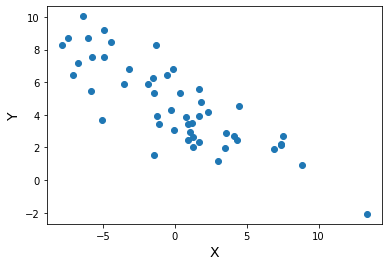

In [ ]:
x=scipy.stats.norm.rvs(0, 5, size=50)
beta0, beta1, sd=5, -.5, 1.5

y_true=x* beta1 + beta0

err= scipy.stats.norm.rvs(0,sd, size=len(x))

y_obs=y_true+err

pyplot.scatter(x,y_obs, )
pyplot.xlabel('X', size=14)
pyplot.ylabel('Y', size=14)


If we wanted to perform a linear regression, we might construct the following linear model:

$$\beta_0, \beta_1 \sim Normal(\mu=0, \sigma=10)$$
$$error \sim Gamma(a=1.5, scale=4)$$

$$\hat{y}_i = \beta_1 x_i + \beta_0$$

$$ y_i \sim Normal(\mu=\hat{y}_i, \sigma=error)$$

Using `ModelBase` as base class we could define this model in a Python class with the following form:


In [ ]:
@Model
class LinearModel(ModelBase):
    def model(self, *args, **kwargs):
        #Define the priors
        beta=self.RV(name='beta',dist='Normal', shape=2, loc=0,scale=10)
        err=self.RV(name='err',dist='Gamma', a=1.5, scale=4)
        
        #Compute the predicted values of Y
        y_pred=x*beta[1]+ beta[0]
        
        #Define the likelihood by creating an RV with a predefined value equal to y_obs
        obs=self.RV(name='Y_obs', dist='Normal',
                    value=y_obs, loc=y_pred, scale=err)

The statistical model itself is defined in the `.model` method of the class. Adding `*args` and `**kwargs` to the method allows additional arguments to be passed to it when called. 

But note three potentially counterintuitive things. First, we didn't define any class methods other than `model`. Second, despite this that we are calling the `self.RV()` class method despite that we apparently haven't even defined it. Third, `.model` doesn't return anything or apparently compute any probabilities. We can do this because `ModelBase` does all of the heavy lifting and supplies our model with additional methods and functionality.

Most of the work is accomplished through calls to the `RV` method of `ModelBase`

In [ ]:
show_doc(ModelBase.RV)

<h4 id="ModelBase.RV" class="doc_header"><code>ModelBase.RV</code><a href="__main__.py#L47" class="source_link" style="float:right">[source]</a></h4>

> <code>ModelBase.RV</code>(**`name`**=*`None`*, **`dist`**=*`None`*, **`value`**=*`None`*, **`shape`**=*`1`*, **`as_dist`**=*`False`*, **`label`**=*`None`*, **`comment`**=*`''`*, **\*`args`**, **\*\*`kwargs`**)

The method which allows models to be constructed programmatically. Calling .RV accomplishes three         things:

1. If RV has not yet been called with the specified name, it adds an RV with         that name to the model

2. If the RV has been called, it evaluates the probability of the RV's current values         and stores this in the RV

3. It returns the current value of the RV
    
Thus the output of RV is numerical and can be operated on like any other number. Equally important,         this means it can be passed as the parameters of another RV.

Note: A number of predefined RVs are inhereted from the `DistributionDefinition` base class, and         using these generally makes for more readable code

****
**Arguments:**

`name` (str): The name of the variable

`dist` (string or instance of the [`Distribution`](/amppl/distributions#Distribution) class): The probability distribution the random variable follows.

`value` (NoneType or numerical): The value of the RV. If None, the RV is treated as an unobserved         variable whose value must be inferred. In this case, the RV is added to the model's parameters.         If a specific value is passed, the RV is not treated as a model parameter which must learned.

`shape` (int): The shape of the RV. Currently only one-dimensional RVs are supported

`as_dist` (bool, default: False): Whether to treat this a a random variable definition or a distribution.         By default, RV defines random variables. If set to true, RV instead returns a dictionary of the form         `{'logp': dist.logp, 'rvs': dist.rvs, 'args': args, 'kwargs':kwargs} which can be used to construct mixture or
transformed distributions.

`label` (str): An optional label that can be used to group parameters together. For         example to separate "parameter" from "hyperparameter".

*args, **kwargs: Arguments to be passed to `dist` when the model is evaluated.

****
**Returns:**

The current values of the RV

Calling `.RV` returns whatever that parameter's current numerical value is. For example, in the defined `.model` method, when we call 

```err=self.RV('err',dist='Gamma', a=1.5, scale=4)```

`err` is not being set to instance of the `RV` class, but rather a `numpy.array` (or more precisely, a Jax `device_array`, which mostly acts like a `numpy.array`). So the variable `err` can be used like any other number, and even be passed as a parameter to other distributions, as is done in the last line:

```obs=self.RV('Y_obs', dist='Normal', value=y_obs, loc=y_pred, scale=err)```

where it describes the size of the regression's residuals.

Underneath the surface, however, `.RV()` accomplishes two other tasks. When `.model()` is called for the first time, `.RV()` does create an instance of the `RV` class with the specified distibution and it stores this in a dictionary called `.RVs` under the name specified by `name`. Further, each time `RV()` is called it also computes log probability of the variable's current value. For example, when 

```err=self.RV('err',dist='Gamma', a=1.5, scale=4)```

is called, under the surface the current value of `err` along with the arguments `a` and `scale` are passed to the logpdf of a Gamma distribution and some log-probability is computed with

```logp=jsc.stats.gamma.logpdf(value, a=a, scale=scale)```

and stored with that RVs name. These are accessed later by the model to compute the full log-probability.

So calling `.model()` evaluates each of these `.RV()` functions in the order that they are written, extracting the current value of each parameter as a number that can be operated on as a number and also computing the respective probabilities internally. 


### More readable model definitions

ModelBase further inherits predefined functions from the `DistributionDefinitions` base class, allowing us to define the same model using a potentially more readable convention:

In [ ]:
@Model
class LinearModel(ModelBase):
    def model(self, *args, **kwargs):
        #Define the priors
        beta=self.Normal(name='beta', shape=2, loc=0,scale=10)
        err=self.Gamma(name='err', a=1.5, scale=4)
        
        #Compute the predicted values of Y
        y_pred=x*beta[1]+ beta[0]
        
        #Define the likelihood by creating an RV with a predefined value equal to y_obs
        obs=self.Normal(name='Y_obs', value=y_obs, loc=y_pred, scale=err)

In [ ]:
LinearModel.RVs['beta'].kwargs

{'loc': 0, 'scale': 10}

To create a vector of unconstrained parameter values of the appropriate length, we can call .generate_vector()

In [ ]:
x0=LinearModel.generate_vector()
print (x0)

[0. 0. 0.]


We can evaluate the probability of these parameters using `.set_state_and_evaluate`

In [ ]:
LinearModel.set_state_and_evaluate(x0)

DeviceArray(-747.88745, dtype=float32)

In [ ]:
samp=LinearModel.sample_from_prior(10)

In [ ]:
samp.sample

array([[ -8.60414526,  14.31891892,  -0.65582615],
       [  6.74543001,   6.70127868,   3.00093579],
       [-23.1080864 ,  -0.92409322,   3.08627033],
       [  1.35941057,  -3.27129073,   2.61275959],
       [-11.96513811,   9.87240811,   1.44303381],
       [ -5.82885062,   3.91525854,   0.52139211],
       [  0.03359838,  19.36230537,   2.91190434],
       [  2.05151927,  -3.90618446,   1.53838122],
       [  5.71819822,   1.98477046,   2.7876966 ],
       [ -5.01327643,  -3.12113412,   1.52480888]])

In [ ]:
LinearModel.RVs['err'].bijection.unconstrained

<bound method HalfBounded.unconstrained of <amppl.distributions.HalfBounded object at 0x7f2c40233d00>>

In [ ]:
LinearModel.rv_labels

[None, None, None]

In [ ]:
def sample_from_rvs(self, size=1000,include=None, exclude=None, constrained=False):
    if isinstance(include, type(None)):
        rv_list=set(self.vector_labels)
    else:
        idx=numpy.isin(self.rv_labels, include)
        print (idx)
        rv_list=set(numpy.array(self.vector_labels)[idx])
    if isinstance(exclude, type(None))==False:
        rv_list-=set(exclude)
    
    sample={}
    for rv in rv_list:
        kwargs=self.RVs[rv].kwargs
        args=self.RVs[rv].args
        shape=self.RVs[rv].shape
        if type(shape)==int:
            shape=[shape]
        else:
            shape=list(shape)
        shape=[size]+shape
        sample[rv]=self.RVs[rv].distribution.rvs(size=shape, *args, **kwargs)
        if constrained==False:
            sample[rv]=self.RVs[rv].bijection.unconstrained(sample[rv])
    return sample
samp=sample_from_rvs(LinearModel,include=['prior'], constrained=False)

[False False False]


In [ ]:
# samp

This both sets the model's parameter state and computes the probabilities. We can find the constrained representation of the parameters in the `.parameters` attribute

In [ ]:
LinearModel.parameters

{'beta': array([-5.01327643, -3.12113412]),
 'err': DeviceArray([4.5942655], dtype=float32),
 'Y_obs': DeviceArray([0.], dtype=float32)}

In [ ]:
# from jax.tree_util import Partial
@partial(jit, static_argnums=1)
def get_parameters(x0,model):
    lp=model.set_state_and_evaluate(x0)    
    return model.parameters
    

In [ ]:
# t=[LinearModel.set_state_and_evaluate(x0) for i in tqdm(range(1000000))]

In [ ]:
from tqdm import tqdm
t=[get_parameters(x0, LinearModel) for i in tqdm(range(1000000))]

100%|██████████| 1000000/1000000 [00:03<00:00, 266651.31it/s]


In [ ]:

LinearModel.parameters

{'beta': Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=0/1)>,
 'err': Traced<ShapedArray(float32[1])>with<DynamicJaxprTrace(level=0/1)>,
 'Y_obs': DeviceArray([0.], dtype=float32)}

If we only want to compute the probabilities associated with some of the parameters separately, we can add labels when defining those RVs.

In [ ]:
@Model
class LinearModel(ModelBase):
    def model(self, *args, **kwargs):
        #Define the priors
        beta=self.Normal(name='beta', shape=2, loc=0,scale=10, label='prior')
        err=self.Gamma(name='err', a=1.5, scale=4, label='prior')
        
        #Compute the predicted values of Y
        y_pred=x*beta[1]+ beta[0]
        
        #Define the likelihood by creating an RV with a predefined value equal to y_obs
        obs=self.Normal(name='Y_obs', value=y_obs, loc=y_pred, scale=err, label='likelihood')

We could compute the prior probabilities either by specifying that we want to compute the priors or by excluding the parameters labeled `likelihood'

In [ ]:
print (LinearModel.set_state_and_evaluate(x0, exclude_labels={'prior'}))
print (LinearModel.set_state_and_evaluate(x0, include_labels={'likelihood'}))

-739.2357
-739.2357


In [ ]:
show_doc(ModelBase.set_state_and_evaluate)

<h4 id="ModelBase.set_state_and_evaluate" class="doc_header"><code>ModelBase.set_state_and_evaluate</code><a href="__main__.py#L169" class="source_link" style="float:right">[source]</a></h4>

> <code>ModelBase.set_state_and_evaluate</code>(**`x`**=*`None`*, **`unconstrained`**=*`True`*, **`random_state`**=*`None`*, **`include_labels`**=*`{}`*, **`exclude_labels`**=*`{}`*, **\*`args`**, **\*\*`kwargs`**)

Set the state of the model's parameters and return the corresponding log-probability
****
**Arguments:**

`x` (1-dimensional array): The values to which the model's state should be set to. 

`unconstrained` (bool): Whether the parameters specified in x need to be transformed 
\satistfy the model's constraints

`include_labels` (set or dict): Only include the log-probability of the RVs with the         specified labels. If not specified, include all RVs (except those specified in `exclude_labels`)

`include_labels` (set or dict): Do not include the log-probability of the RVs with the         specified labels. If not specified, not RVs will be excluded.

`args`, `kwargs` - Additional arguments to be passed to [`model`](/amppl/model)

****
**Returns:** The log-probability of the specified state evaluated by calling `compute_logprob`

In [ ]:
@Model
class LinearModel(ModelBase):
    def model(self, *args, **kwargs):
        #Define the priors
        beta=self.Normal(name='beta', shape=2, loc=0,scale=10)
        err=self.Gamma(name='err', a=1.5, scale=4)
        test=self.Normal('test',as_dist=True, loc=0, scale=.5)
        reg=jnp.sum(test['dist'].logp(beta, **test['kwargs']))
        adj=self.AdjustEvidence('adj', value=reg)
        
        #Compute the predicted values of Y
        y_pred=x*beta[1]+ beta[0]
        
        #Define the likelihood by creating an RV with a predefined value equal to y_obs
        obs=self.Normal(name='Y_obs', value=y_obs, loc=y_pred, scale=err)

In [ ]:
x0=LinearModel.generate_vector()
print (x0)

[0. 0. 0.]


In [ ]:
obj_func=lambda x: -LinearModel.set_state_and_evaluate(x)
fast_func=jit(obj_func)
grad_func=grad(obj_func)

In [ ]:
grad_func(x0)

DeviceArray([ -230.08517,   484.685  , -1336.8278 ], dtype=float32)

In [ ]:
LinearModel.set_state_and_evaluate(x0)

DeviceArray(-748.339, dtype=float32)

In [ ]:
LinearModel.RVs['adj'].current_logprob

DeviceArray(-0.45158273, dtype=float32)